In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter

from going_modular import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

from collections import Counter
from rpy2.robjects import Formula
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import r
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import DataFrame, FloatVector, IntVector, ListVector, Vector, StrVector

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")
graphics = importr("graphics")
stats = importr("stats")
lmtest = importr("lmtest")

In [2]:
lical0 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/lical0_processed_data_for_fp_model_21-01-2026.csv')
miro0 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/miro0_processed_data_for_fp_model_21-01-2026.csv')
miroli0 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/miroli0_processed_data_for_fp_model_21-01-2026.csv')
ril_3010 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/ril_3010_processed_data_for_fp_model_21-01-2026.csv')
proact0 = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/DataFile/proact0_processed_data_for_fp_model_21-01-2026.csv')

In [3]:
miroli0.head(3)

,subject_id,Event,Disease_Duration,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0,32.600526,1,-0.355001,-0.075830,0.363265,0.828441,1,1,1,-0.355001,-0.355001,0.026920
1,P01002,1,41.538765,1,0.255274,-1.168542,1.103061,0.398812,1,0,0,0.000000,0.255274,-0.298299
2,P01003,0,34.571616,0,-1.123785,-1.189109,0.616453,0.563821,1,1,1,-1.123785,-1.123785,1.336303


In [4]:
miroli0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         396 non-null    object 
 1   Event              396 non-null    int64  
 2   Disease_Duration   396 non-null    float64
 3   Study_Arm_Placebo  396 non-null    int64  
 4   Age                396 non-null    float64
 5   TRICALS            396 non-null    float64
 6   Diagnostic_Delay   396 non-null    float64
 7   Vital_capacity     396 non-null    float64
 8   Onset_Limb         396 non-null    int64  
 9   Sex_Male           396 non-null    int64  
 10  Sex_onset          396 non-null    int64  
 11  Age_Sex            396 non-null    float64
 12  Age_onset          396 non-null    float64
 13  Age_TRICALS        396 non-null    float64
dtypes: float64(8), int64(5), object(1)
memory usage: 43.4+ KB


## **Second attempt on Bootstrapping, calibration slope, regression coefficients, CI.**

In [5]:
# --- helpers ---
def r_cindex(concordance_obj):
    concord_vec = ro.r('function(x) x$concordance')(concordance_obj)
    return float(concord_vec[0])

def predict_lp_stpm2(model, newdata):
    """
    Compute linear predictor Xβ for stpm2 model using lpmatrix * coef.
    """
    X = ro.r['predict'](model, newdata=newdata, type="lpmatrix")
    beta = ro.r['coef'](model)
    return ro.r['as.numeric'](X @ beta)


def coef_dict_stpm2(model):
    """
    Return named coefficient dict for stpm2.
    coef(model) includes baseline/spline terms too, so we must map by name.
    """
    coef_vec = ro.r['coef'](model)
    nms = list(ro.r['names'](coef_vec))
    vals = list(coef_vec)
    out = {}
    for k, v in zip(nms, vals):
        out[str(k)] = float(v)
    return out

def safe_get_beta(beta_dict, vars_list):
    """
    Extract only requested covariate coefficients.
    If a term isn't found (e.g., factor level naming), it will be omitted.
    """
    return {v: beta_dict[v] for v in vars_list if v in beta_dict}

def r_neg(x):
    return ro.r['-'](x)   # R's unary minus

# Add a helper to get predicted survival at t0 from stpm2
def predict_surv_stpm2_at_t0(model, newdata, t0):
    """
    Predict survival S(t0 | x) from stpm2 model for each row in newdata at a certain time point.
    Returns an R numeric vector (FloatVector).
    """
    # stpm2 predict: type="surv" and newdata; timevar usually "t" via "timevar"
    # We create a copy with a column t0 and use timevar="t0".
    tmp = ro.r("transform")(newdata, t0=ro.FloatVector([t0] * int(ro.r("nrow")(newdata)[0])))
    return ro.r['predict'](model, newdata=tmp, type="surv", timevar="t0")

# Add Kaplan–Meier observed risk at t0
def km_risk_at_t0(r_df, t0):
    """
    KM estimate of event risk at t0: 1 - S_KM(t0)
    """
    survfit = survival.survfit
    fit = survfit(ro.Formula("Surv(Disease_Duration, Event==1) ~ 1"), data=r_df)
    # summary(fit, times=t0)$surv gives S(t0)
    s = ro.r('summary')(fit, times=ro.FloatVector([t0]))[0]  # might vary by rpy2; safer below


# Then p_obs = 1 - km_surv_at_t0(...)
def km_surv_at_t0(r_df, t0):
    f = ro.r("""
    function(df, t0){
      fit <- survival::survfit(survival::Surv(Disease_Duration, Event==1) ~ 1, data=df)
      s <- summary(fit, times=t0)$surv
      if(length(s)==0) return(NA_real_)
      as.numeric(s[1])
    }
    """)
    return float(f(r_df, t0)[0])

def logit(p):
    p = min(max(p, 1e-12), 1-1e-12)
    return np.log(p/(1-p))

def inv_logit(x):
    x = float(x)
    return 1 / (1 + np.exp(-x))

def citl_at_t0(model, r_df, t0_months):
    """
    CITL(t0) = logit(p_obs(t0)) - logit(mean(p_pred(t0)))
    """
    S_pred = predict_surv_stpm2_at_t0(model, r_df, t0_months)
    p_pred = 1.0 - np.array(S_pred, dtype=float)
    p_bar = float(np.mean(p_pred))

    S_km = km_surv_at_t0(r_df, t0_months)
    if np.isnan(S_km):
        return np.nan

    p_obs = 1.0 - float(S_km)
    return float(logit(p_obs) - logit(p_bar))

def km_risk_ci_at_t0(r_df_sub, t0_months):
    """
    Returns (risk, risk_lo, risk_hi) at t0 using KM with Greenwood CI.
    """
    f = ro.r("""
    function(df, t0){
      fit <- survival::survfit(survival::Surv(Disease_Duration, Event==1) ~ 1, data=df)
      ss <- summary(fit, times=t0)
      if(length(ss$surv)==0) return(c(NA_real_, NA_real_, NA_real_))
      S  <- as.numeric(ss$surv[1])
      Lo <- as.numeric(ss$lower[1])
      Hi <- as.numeric(ss$upper[1])
      # convert survival CI to risk CI
      risk    <- 1 - S
      risk_lo <- 1 - Hi
      risk_hi <- 1 - Lo
      c(risk, risk_lo, risk_hi)
    }
    """)
    out = f(r_df_sub, float(t0_months))
    vals = np.array(out, dtype=float)
    if np.any(~np.isfinite(vals)):
        return (np.nan, np.nan, np.nan)
    return tuple(vals)



In [6]:
# Assumes these are already defined in your environment:
#   rstpm2, survival, stats
#   predict_lp_stpm2, coef_dict_stpm2, safe_get_beta
#   r_cindex, r_cindex (helper to extract concordance from R object)
#   r_neg (helper to negate LP if desired)
#   citl_at_t0 (your function computing CITL at t0)
#
# NOTE: I removed the confusing fail-safe block that tried to compute
#       citl_corrected inside the exception. We compute corrected values once at the end.


def eval_stpm2_with_bootstrap_validation(
    df_python: pd.DataFrame,
    vars_list: list,
    spline_df: int,
    n_boot: int = 200,
    random_state: int | None = None,
    t0_months: int | None = None,
    hard_include: list | None = None,
    hard_exclude: list | None = None,
    keep_unique: bool = True,
    negate_lp_for_slope: bool = True,):
    """
    Fit stpm2 and compute:
      - AIC (apparent)
      - C-index (apparent + optimism-corrected + 95% bootstrap percentile CI)
      - Calibration slope (apparent + optimism-corrected + 95% bootstrap percentile CI)
          * slope computed via Cox PH on the model LP (or -LP if negate_lp_for_slope=True)
      - Coefficients (apparent + bootstrap-based optimism correction + 95% CI)
      - CITL at t0_months (apparent + optimism-corrected + 95% CI)

    Hard-coded variable control:
      - hard_include: variables always forced into model RHS (even if not in vars_list)
      - hard_exclude: variables removed even if present
      - keep_unique: de-duplicate variables while preserving order
    """

    # -----------------------------
    # defaults and input handling
    # -----------------------------
    if t0_months is None:
        t0_months = 24

    if hard_include is None:
        hard_include = []
    if hard_exclude is None:
        hard_exclude = []

    # Work on a copy, ensure 0..n-1 index
    df_python = df_python.reset_index(drop=True).copy()

    # Build final variable list with forced include/exclude
    vars_list = list(vars_list) if vars_list else []
    final_vars = vars_list + list(hard_include)

    # drop excluded
    final_vars = [v for v in final_vars if v not in set(hard_exclude)]

    # de-duplicate (preserve order)
    if keep_unique:
        seen = set()
        final_vars_uniq = []
        for v in final_vars:
            if v not in seen:
                seen.add(v)
                final_vars_uniq.append(v)
        final_vars = final_vars_uniq

    # If empty, intercept-only
    rhs = " + ".join(final_vars) if final_vars else "1"
    formula_str = f"Surv(Disease_Duration, Event==1) ~ {rhs}"
    formula = Formula(formula_str)

    # Seed
    rng = np.random.default_rng(random_state)

    # Convert full data to R
    with localconverter(default_converter + pandas2ri.converter):
        r_df = pandas2ri.py2rpy(df_python)

    r_coef = ro.r["coef"]
    coxph = survival.coxph

    # -----------------------------
    # fit on full data (apparent)
    # -----------------------------
    model_full = rstpm2.stpm2(formula, data=r_df, df=spline_df)
    aic_full = float(stats.AIC(model_full)[0])

    lp_full = predict_lp_stpm2(model_full, r_df)  # numeric vector (R)
    lp_full_survival = lp_full

    # For slope we often want risk direction consistent with "higher = worse"
    lp_full_for_slope = r_neg(lp_full_survival) if negate_lp_for_slope else lp_full_survival

    # Apparent C-index
    r_df_cindex = ro.r("transform")(r_df, predicted=lp_full_survival)
    c_index_app = r_cindex(
        survival.concordance(
            ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
            data=r_df_cindex
        )
    )

    # Apparent calibration slope (Cox PH on LP)
    r_df_cal = ro.r("transform")(r_df, predicted=lp_full_for_slope)
    cal_model_app = coxph(
        ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
        data=r_df_cal
    )
    slope_app = float(np.array(r_coef(cal_model_app))[0])

    # Apparent covariate coefficients (covariates only)
    beta_full_all = coef_dict_stpm2(model_full)
    beta_app = safe_get_beta(beta_full_all, final_vars)

    # Apparent CITL
    citl_app = float(citl_at_t0(model_full, r_df, t0_months))

    # -----------------------------
    # bootstrap optimism
    # -----------------------------
    n = len(df_python)

    cindex_diff, slope_diff, citl_diff = [], [], []
    cindex_out_all, slope_out_all, citl_out_all = [], [], []

    coeff_boot_diff = {var: [] for var in beta_app.keys()}
    coeff_out_all = {var: [] for var in beta_app.keys()}

    for _ in range(n_boot):
        # sample indices with replacement (0..n-1)
        sample_idx = rng.integers(0, n, size=n)
        boot_df = df_python.iloc[sample_idx].reset_index(drop=True)

        with localconverter(default_converter + pandas2ri.converter):
            r_boot = pandas2ri.py2rpy(boot_df)

        try:
            model_boot = rstpm2.stpm2(formula, data=r_boot, df=spline_df)

            # ---- CITL optimism ----
            citl_boot_in = float(citl_at_t0(model_boot, r_boot, t0_months))
            citl_boot_out = float(citl_at_t0(model_boot, r_df, t0_months))
            citl_diff.append(citl_boot_in - citl_boot_out)
            citl_out_all.append(citl_boot_out)

            # ---- In-bootstrap: C-index & slope ----
            lp_boot_in = predict_lp_stpm2(model_boot, r_boot)
            lp_boot_in_survival = lp_boot_in
            lp_boot_in_for_slope = r_neg(lp_boot_in_survival) if negate_lp_for_slope else lp_boot_in_survival

            r_boot_in_cindex = ro.r("transform")(r_boot, predicted=lp_boot_in_survival)
            c_boot = r_cindex(
                survival.concordance(
                    ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                    data=r_boot_in_cindex
                )
            )

            r_boot_in_cal = ro.r("transform")(r_boot, predicted=lp_boot_in_for_slope)
            cal_boot = coxph(
                ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                data=r_boot_in_cal
            )
            slope_boot = float(np.array(r_coef(cal_boot))[0])

            # ---- Out-of-bootstrap: evaluate boot model on full data ----
            lp_out = predict_lp_stpm2(model_boot, r_df)
            lp_out_survival = lp_out
            lp_out_for_slope = r_neg(lp_out_survival) if negate_lp_for_slope else lp_out_survival

            r_out_cindex = ro.r("transform")(r_df, predicted=lp_out_survival)
            c_out = r_cindex(
                survival.concordance(
                    ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                    data=r_out_cindex
                )
            )

            r_out_cal = ro.r("transform")(r_df, predicted=lp_out_for_slope)
            cal_out = coxph(
                ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
                data=r_out_cal
            )
            slope_out = float(np.array(r_coef(cal_out))[0])

            cindex_diff.append(c_boot - c_out)
            slope_diff.append(slope_boot - slope_out)

            cindex_out_all.append(c_out)
            slope_out_all.append(slope_out)

            # ---- Coefficient optimism (covariates only, by name) ----
            beta_boot_all = coef_dict_stpm2(model_boot)
            beta_boot = safe_get_beta(beta_boot_all, list(beta_app.keys()))

            for var in beta_app.keys():
                diff = beta_boot.get(var, np.nan) - beta_app[var]
                if np.isnan(diff):
                    diff = 0.0
                coeff_boot_diff[var].append(diff)
                coeff_out_all[var].append(beta_app[var] - diff)

        except Exception:
            # Conservative fallback: treat as no optimism; keep apparent values for this iteration
            cindex_diff.append(0.0)
            slope_diff.append(0.0)
            citl_diff.append(0.0)

            cindex_out_all.append(c_index_app)
            slope_out_all.append(slope_app)
            citl_out_all.append(citl_app)

            for var in beta_app.keys():
                coeff_boot_diff[var].append(0.0)
                coeff_out_all[var].append(beta_app[var])

    # -----------------------------
    # optimism-corrected metrics
    # -----------------------------
    c_index_corr = c_index_app - float(np.mean(cindex_diff)) if cindex_diff else c_index_app
    slope_corr = slope_app - float(np.mean(slope_diff)) if slope_diff else slope_app
    citl_corr = citl_app - float(np.mean(citl_diff)) if citl_diff else citl_app

    cindex_ci = np.percentile(cindex_out_all, [2.5, 97.5]) if cindex_out_all else (np.nan, np.nan)
    slope_ci = np.percentile(slope_out_all, [2.5, 97.5]) if slope_out_all else (np.nan, np.nan)
    citl_ci = np.percentile(citl_out_all, [2.5, 97.5]) if citl_out_all else (np.nan, np.nan)

    beta_corr = {var: beta_app[var] - float(np.mean(coeff_boot_diff[var])) for var in beta_app.keys()}
    beta_ci = {var: np.percentile(coeff_out_all[var], [2.5, 97.5]) for var in beta_app.keys()}

    return {
        "vars_requested": vars_list.copy(),
        "vars_forced_in": list(hard_include),
        "vars_excluded": list(hard_exclude),
        "vars_final": final_vars.copy(),
        "spline_df": spline_df,
        "aic": aic_full,

        "cindex_app": c_index_app,
        "cindex_corr": c_index_corr,
        "cindex_ci": cindex_ci,

        "slope_app": slope_app,
        "slope_corr": slope_corr,
        "slope_ci": slope_ci,

        "beta_app": beta_app,
        "beta_corr": beta_corr,
        "beta_ci": beta_ci,

        "citl_app": citl_app,
        "citl_corrected": citl_corr,
        "citl_ci": citl_ci,

        "t0_months": t0_months,
        "formula": formula_str,
    }


In [7]:
# --- selection by AIC with reporting ---

def find_best_model_by_aic_with_bootstrap_report(
    train_df,
    covariates,
    df_candidates,
    n_boot=200,
    random_state=None,
    tie_breaker="cindex_corr",
    t0_months=24,
    hard_include=None,
    hard_exclude=None,
    keep_unique=True,
):
    """
    Backward elimination where selection criterion is AIC (lowest).
    Reports bootstrap-validated C-index, calibration slope, and CITL.

    tie_breaker:
      - "cindex_corr": if AIC ties, pick higher optimism-corrected C-index
      - "cindex_app":  if AIC ties, pick higher apparent C-index
      - None:          pure AIC

    hard_include: list of variables forced into every model
    hard_exclude: list of variables never allowed
    """

    if hard_include is None:
        hard_include = []
    if hard_exclude is None:
        hard_exclude = []

    hard_include = list(hard_include)
    hard_exclude = list(hard_exclude)

    # Remove excluded from starting set, and ensure forced are present
    start_vars = [v for v in covariates if v not in set(hard_exclude)]
    for v in hard_include:
        if v not in start_vars and v not in set(hard_exclude):
            start_vars.append(v)

    # Don't allow forced variables to be removed during backward elimination
    forced_set = set(hard_include)

    selection_counts = Counter()
    current_vars = start_vars.copy()
    best_result = None

    rng = np.random.default_rng(random_state)

    def better(a, b):
        """Return True if a is better than b under AIC selection (+ optional tie-break)."""
        if b is None:
            return True
        if a["aic"] < b["aic"] - 1e-12:
            return True
        if abs(a["aic"] - b["aic"]) <= 1e-12 and tie_breaker:
            return a[tie_breaker] > b[tie_breaker]
        return False

    while len(current_vars) >= 1:
        candidates = []

        # Use a different seed per "outer iteration" so it's reproducible but not identical forever
        # (makes candidate comparisons fair within the iteration if you want; optional)
        iter_seed = int(rng.integers(0, 2**31 - 1))

        # 1) Evaluate current model for each spline df
        for df_spline in df_candidates:
            res = eval_stpm2_with_bootstrap_validation(
                df_python=train_df,
                vars_list=current_vars,
                spline_df=df_spline,
                n_boot=n_boot,
                random_state=iter_seed,      # same bootstrap draws within this iteration
                t0_months=t0_months,
                hard_include=hard_include,
                hard_exclude=hard_exclude,
                keep_unique=keep_unique,
            )
            candidates.append(res)

        # 2) Try removing each non-forced variable (for each df)
        removable = [v for v in current_vars if v not in forced_set]

        for var in removable:
            test_vars = [v for v in current_vars if v != var]
            if len(test_vars) == 0:
                continue
            for df_spline in df_candidates:
                res = eval_stpm2_with_bootstrap_validation(
                    df_python=train_df,
                    vars_list=test_vars,
                    spline_df=df_spline,
                    n_boot=n_boot,
                    random_state=iter_seed,  # same bootstrap draws within this iteration
                    t0_months=t0_months,
                    hard_include=hard_include,
                    hard_exclude=hard_exclude,
                    keep_unique=keep_unique,
                )
                candidates.append(res)

        # choose best candidate by AIC (+ tie-break)
        cand_best = None
        for c in candidates:
            if better(c, cand_best):
                cand_best = c

        # Update selection frequencies using the *actual fitted variables*
        selection_counts.update(cand_best["vars_final"])

        # Stop if no AIC improvement compared to previous best_result
        if best_result is not None and cand_best["aic"] >= best_result["aic"] - 1e-12:
            break

        best_result = cand_best

        # Continue elimination using the fitted variable list
        # (this ensures forced include/exclude is respected across steps)
        current_vars = best_result["vars_final"].copy()

        # Safety: if only forced variables remain, can't reduce further
        if all(v in forced_set for v in current_vars):
            break

    # ---- print summary ----
    print("\nSelected model (AIC-based selection; bootstrap validation reported):")
    print("Variables (final):", best_result["vars_final"])
    print("Forced in:", best_result["vars_forced_in"])
    print("Excluded:", best_result["vars_excluded"])
    print("Spline df:", best_result["spline_df"])
    print("AIC (apparent):", best_result["aic"])
    print("Formula:", best_result["formula"])

    print("\nC-index:")
    print("  Apparent:", best_result["cindex_app"])
    print("  Optimism-corrected:", best_result["cindex_corr"], "95% CI:", best_result["cindex_ci"])

    print("\nCalibration slope:")
    print("  Apparent:", best_result["slope_app"])
    print("  Optimism-corrected:", best_result["slope_corr"], "95% CI:", best_result["slope_ci"])

    print(f"\nCalibration-in-the-large at {best_result['t0_months']} months:")
    print("  Apparent:", best_result["citl_app"])
    print("  Optimism-corrected:", best_result["citl_corrected"], "95% CI:", best_result["citl_ci"])

    print("\nCovariate coefficients (covariates only):")
    for var in best_result["vars_final"]:
        if var in best_result["beta_corr"]:
            lo, hi = best_result["beta_ci"][var]
            print(f"  {var}: {best_result['beta_corr'][var]}  95% CI: [{lo}, {hi}]")
        else:
            print(f"  {var}: (not found in coef names; check factor/term naming)")

    print("\nVariable selection frequencies (across visited best-steps):")
    for var in [v for v in covariates if v not in set(hard_exclude)] + [v for v in hard_include if v not in set(hard_exclude)]:
        print(f"  {var}: {selection_counts[var]}")

    return best_result, selection_counts


In [8]:
miroli0.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [18]:
# Define your initial covariates and spline degrees of freedom
covariates = ['Study_Arm_Placebo', 'Age', 'Diagnostic_Delay', 'Vital_capacity', 
              'Onset_Limb', 'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset']

forced_vars = ['Age', 'Diagnostic_Delay', 'Onset_Limb', 'Sex_Male']


df_candidates = [1]

t0_months = 24  # prediction horizon for CITL

# # Set number of bootstrap samples
n_boot = 5  # can increase for more stable estimates

dat_set = miroli0.copy()

best_result, selection_counts = find_best_model_by_aic_with_bootstrap_report(
                                                                                train_df=dat_set,
                                                                                covariates=covariates,        # full candidate pool
                                                                                df_candidates=df_candidates,  # spline df options
                                                                                n_boot=n_boot,
                                                                                random_state=None,
                                                                                tie_breaker="cindex_corr",
                                                                                t0_months=t0_months,
                                                                                hard_include=['Age', 'Diagnostic_Delay', 'Onset_Limb', 'Sex_Male'],
                                                                                hard_exclude=None             # or [] if you prefer
                                                                            )


Selected model (AIC-based selection; bootstrap validation reported):
Variables (final): ['Age', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset']
Forced in: ['Age', 'Diagnostic_Delay', 'Onset_Limb', 'Sex_Male']
Excluded: []
Spline df: 1
AIC (apparent): 1469.3216090555184
Formula: Surv(Disease_Duration, Event==1) ~ Age + Diagnostic_Delay + Vital_capacity + Onset_Limb + Sex_Male + Sex_onset

C-index:
  Apparent: 0.7478968096758407
  Optimism-corrected: 0.7520209802672091 95% CI: [0.73053529 0.79834075]

Calibration slope:
  Apparent: 1.173233842097786
  Optimism-corrected: 1.1744332535977922 95% CI: [1.07244672 1.48432258]

Calibration-in-the-large at 24 months:
  Apparent: -0.4817746154335859
  Optimism-corrected: -0.4794724202589689 95% CI: [-0.58538214 -0.40671197]

Covariate coefficients (covariates only):
  Age: 0.42515240304895763  95% CI: [0.36684607232467537, 0.47464259123617886]
  Diagnostic_Delay: -0.662004126418271  95% CI: [-0.7402463600001608, -0.

In [19]:
# 1) Slide-ready "key results" table (2 columns)
def make_slide_summary_table(best_result, t0_months):
    rows = []

    def add(metric, value=None, ci=None):
        rows.append({"Metric": metric, "Value": value, "95% CI": ci})

    # Use vars_final if present (forced vars etc.), else fallback
    vars_final = best_result.get("vars_final", best_result.get("vars", []))
    add("Selected variables", ", ".join(vars_final))
    add("Spline df", best_result.get("spline_df", None))
    add("AIC (apparent)", best_result.get("aic", None))

    # C-index
    add("C-index (apparent)", best_result.get("cindex_app", None))
    c_ci = best_result.get("cindex_ci", None)
    add(
        "C-index (optimism-corrected)",
        best_result.get("cindex_corr", None),
        f"[{c_ci[0]:.3f}, {c_ci[1]:.3f}]" if c_ci is not None else None
    )

    # Calibration slope
    add("Calibration slope (apparent)", best_result.get("slope_app", None))
    s_ci = best_result.get("slope_ci", None)
    add(
        "Calibration slope (optimism-corrected)",
        best_result.get("slope_corr", None),
        f"[{s_ci[0]:.3f}, {s_ci[1]:.3f}]" if s_ci is not None else None
    )

    # CITL
    add(f"CITL at {t0_months} months (apparent)", best_result.get("citl_app", None))
    citl_ci = best_result.get("citl_ci", None)
    add(
        f"CITL at {t0_months} months (optimism-corrected)",
        best_result.get("citl_corrected", None),
        f"[{citl_ci[0]:.3f}, {citl_ci[1]:.3f}]" if citl_ci is not None else None
    )

    df = pd.DataFrame(rows, columns=["Metric", "Value", "95% CI"])

    # Slide-friendly formatting
    def fmt_num(x):
        if isinstance(x, (int, float)) and pd.notnull(x):
            return f"{x:.3f}"
        return x

    df["Value"] = df["Value"].apply(fmt_num)
    return df


# 2) Slide-ready coefficients table (only selected covariates)
def make_slide_coeff_table(best_result):
    beta = best_result.get("beta_corr", {})
    beta_ci = best_result.get("beta_ci", {})
    vars_final = best_result.get("vars_final", [])

    rows = []
    for v in vars_final:
        if v in beta:
            lo, hi = beta_ci.get(v, (None, None))
            rows.append({
                "Variable": v,
                "Beta": f"{beta[v]:.3f}",
                "95% CI": f"[{lo:.3f}, {hi:.3f}]" if lo is not None and hi is not None else ""
            })

    return pd.DataFrame(rows)


# 3) Selection frequencies table
def make_slide_selection_freq_table(selection_counts, covariates):
    rows = [{"Variable": v, "Selection count": int(selection_counts.get(v, 0))} for v in covariates]
    df = pd.DataFrame(rows).sort_values("Selection count", ascending=False).reset_index(drop=True)
    return df


# ---- build tables ----
summary_tbl = make_slide_summary_table(best_result, t0_months=t0_months)
coef_tbl = make_slide_coeff_table(best_result)
freq_tbl = make_slide_selection_freq_table(selection_counts, covariates)

# display in notebook
display(summary_tbl)
display(coef_tbl)
display(freq_tbl)

# optional: export to CSV for easy copy-paste into slides
# summary_tbl.to_csv("/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/miroli_trical_slide_model_summary.csv", index=False)
# coef_tbl.to_csv("/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/miroli_trical_slide_model_coefficients.csv", index=False)
# freq_tbl.to_csv("/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/miroli_trical_slide_variable_selection_frequencies.csv", index=False)

print("Saved: miroli_trical_slide_model_summary.csv, miroli_trical_slide_model_coefficients.csv, miroli_trical_slide_variable_selection_frequencies.csv")


,Metric,Value,95% CI
0,Selected variables,"Age, Diagnostic_Delay, Vital_capacity, Onset_L...",None
1,Spline df,1.000,None
2,AIC (apparent),1469.322,None
3,C-index (apparent),0.748,None
4,C-index (optimism-corrected),0.752,"[0.731, 0.798]"
5,Calibration slope (apparent),1.173,None
6,Calibration slope (optimism-corrected),1.174,"[1.072, 1.484]"
7,CITL at 24 months (apparent),-0.482,None
8,CITL at 24 months (optimism-corrected),-0.479,"[-0.585, -0.407]"


,Variable,Beta,95% CI
0,Age,0.425,"[0.367, 0.475]"
1,Diagnostic_Delay,-0.662,"[-0.740, -0.599]"
2,Vital_capacity,-0.518,"[-0.615, -0.389]"
3,Onset_Limb,0.366,"[-0.311, 0.860]"
4,Sex_Male,0.403,"[-0.185, 1.019]"
5,Sex_onset,-0.846,"[-1.646, -0.150]"


,Variable,Selection count
0,Age,4
1,Diagnostic_Delay,4
2,Vital_capacity,4
3,Onset_Limb,4
4,Sex_Male,4
5,Sex_onset,4
6,Age_Sex,2
7,Age_onset,1
8,Study_Arm_Placebo,0


Saved: miroli_trical_slide_model_summary.csv, miroli_trical_slide_model_coefficients.csv, miroli_trical_slide_variable_selection_frequencies.csv


In [20]:
with localconverter(default_converter + pandas2ri.converter):
        r_df = pandas2ri.py2rpy(dat_set)

final_formula = Formula(
    "Surv(Disease_Duration, Event==1) ~ " + " + ".join(best_result["vars_final"])
)

model_final = rstpm2.stpm2(
    final_formula,
    data=r_df,
    df=best_result["spline_df"]
)
df_coef = extract_coefficients_from_fp_model_log_haz_scale(model_final)
df_coef = round(df_coef, 4)
df_coef

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),LHR,CI_lower,CI_upper,Significant
0,Age,0.3773,0.0902,4.1826,0.0000,0.3773,0.2005,0.5541,True
1,Diagnostic_Delay,-0.6175,0.0767,-8.0461,0.0000,-0.6175,-0.7679,-0.4671,True
2,Vital_capacity,-0.4748,0.0862,-5.5106,0.0000,-0.4748,-0.6437,-0.3059,True
3,Onset_Limb,0.3486,0.2854,1.2214,0.2219,0.3486,-0.2108,0.9079,False
4,Sex_Male,0.2386,0.3344,0.7134,0.4756,0.2386,-0.4169,0.8940,False
5,Sex_onset,-0.7451,0.3856,-1.9323,0.0533,-0.7451,-1.5009,0.0107,False


In [12]:
# print(ro.r('summary')(model_final))

In [21]:
# PART A — Apply uniform shrinkage to an stpm2 model
# Extract coefficients and apply shrinkage
shrinkage = 1 / best_result["slope_corr"]   # ≈ 0.80

beta_full = coef_dict_stpm2(model_final)     # all coefficients
# beta_full
beta_vars = safe_get_beta(beta_full, best_result["vars_final"])
# beta_vars
beta_shrunk = {k: v * shrinkage for k, v in beta_vars.items()}
beta_shrunk_df = pd.DataFrame({
    "Variable": list(beta_shrunk.keys()),
    "Coefficient_shrunk": list(beta_shrunk.values())
})
beta_shrunk_df = beta_shrunk_df.round(4)
beta_shrunk_df

,Variable,Coefficient_shrunk
0,Age,0.3213
1,Diagnostic_Delay,-0.5258
2,Vital_capacity,-0.4043
3,Onset_Limb,0.2968
4,Sex_Male,0.2031
5,Sex_onset,-0.6344


In [22]:
# PART B — External validation of the final model with baseline hazard update

def km_surv_at_t0(r_df, t0):
    f = ro.r("""
    function(df, t0){
      fit <- survival::survfit(survival::Surv(Disease_Duration, Event==1) ~ 1, data=df)
      ss <- summary(fit, times=t0)
      if(length(ss$surv)==0) return(NA_real_)
      as.numeric(ss$surv[1])
    }
    """)
    return float(f(r_df, float(t0))[0])

def km_risk_ci_at_t0(r_df, t0):
    f = ro.r("""
    function(df, t0){
      fit <- survival::survfit(survival::Surv(Disease_Duration, Event==1) ~ 1, data=df)
      ss <- summary(fit, times=t0)
      if(length(ss$surv)==0) return(c(NA_real_, NA_real_, NA_real_))
      S  <- as.numeric(ss$surv[1])
      Lo <- as.numeric(ss$lower[1])
      Hi <- as.numeric(ss$upper[1])
      risk    <- 1 - S
      risk_lo <- 1 - Hi
      risk_hi <- 1 - Lo
      c(risk, risk_lo, risk_hi)
    }
    """)
    return np.array(f(r_df, float(t0)), dtype=float)

def pred_surv_at_t0_stpm2(model, r_df, t0):
    n = int(ro.r("nrow")(r_df)[0])
    tmp = ro.r("transform")(r_df, t0=ro.FloatVector([float(t0)] * n))
    S = ro.r["predict"](model, newdata=tmp, type="surv", timevar="t0")
    return np.array(S, dtype=float)

def calibration_bins_km(r_df, pred_risk, t0, n_bins=5):
    df = pd.DataFrame({"pred": np.asarray(pred_risk, float)})
    df["bin"] = pd.qcut(df["pred"], q=n_bins, duplicates="drop")

    rows = []
    for b in df["bin"].cat.categories:
        mask = (df["bin"] == b).to_numpy()
        idx0 = np.where(mask)[0]
        if len(idx0) == 0:
            continue

        r_sub = r_df.rx(IntVector((idx0 + 1).tolist()), True)
        risk, lo, hi = km_risk_ci_at_t0(r_sub, t0)
        if not np.isfinite(risk):
            continue

        rows.append({
            "bin": str(b),
            "n": int(mask.sum()),
            "mean_pred": float(df.loc[mask, "pred"].mean()),
            "obs_km": float(risk),
            "obs_lo": float(lo),
            "obs_hi": float(hi),
        })

    return pd.DataFrame(rows)

def external_validate_stpm2(
    model_final,
    ext_df: pd.DataFrame,
    vars_final: list,
    t0_months: int,
    shrinkage: float = 1.0,  # e.g. 1 / slope_corr from development
    n_bins: int = 5,
    baseline_update: bool = True,
):
    # --- convert external df to R (keep needed cols) ---
    ext_df = ext_df.reset_index(drop=True).copy()
    needed = ["Disease_Duration", "Event"] + list(vars_final)
    missing = [c for c in needed if c not in ext_df.columns]
    if missing:
        raise ValueError(f"External df missing columns: {missing}")

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_ext = pandas2ri.py2rpy(ext_df[needed])

    # --- LP metrics (direction already confirmed) ---
    lp = np.array(predict_lp_stpm2(model_final, r_ext), dtype=float)
    lp_shrunk = shrinkage * lp

    r_ext_lp = ro.r("transform")(r_ext, predicted=ro.FloatVector(lp_shrunk.tolist()))

    cindex = r_cindex(
        survival.concordance(
            ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
            data=r_ext_lp
        )
    )

    cal_model = survival.coxph(
        ro.Formula("Surv(Disease_Duration, Event==1) ~ predicted"),
        data=r_ext_lp
    )
    slope = float(np.array(ro.r["coef"](cal_model), dtype=float)[0])

    # --- Frozen baseline absolute risk at t0 ---
    S_pred = pred_surv_at_t0_stpm2(model_final, r_ext, t0_months)
    risk_frozen = 1.0 - S_pred

    # --- Observed KM survival at t0 ---
    S_obs = km_surv_at_t0(r_ext, t0_months)

    # --- Baseline update at t0 (log cumulative hazard scale) ---
    if not np.isfinite(S_obs):
        factor = np.nan
        risk_updated = risk_frozen.copy()
    else:
        # clip to avoid log(0)
        S_obs_c = float(np.clip(S_obs, 1e-12, 1 - 1e-12))
        S_bar_c = float(np.clip(np.mean(S_pred), 1e-12, 1 - 1e-12))

        alpha = np.log(-np.log(S_obs_c)) - np.log(-np.log(S_bar_c))
        factor = float(np.exp(alpha))

        if baseline_update:
            S_upd = np.power(S_pred, factor)
            risk_updated = 1.0 - S_upd
        else:
            risk_updated = risk_frozen.copy()

    # --- calibration tables ---
    cal_frozen = calibration_bins_km(r_ext, risk_frozen, t0_months, n_bins=n_bins)
    cal_updated = calibration_bins_km(r_ext, risk_updated, t0_months, n_bins=n_bins)

    return {
        "t0_months": t0_months,
        "vars_final": list(vars_final),
        "shrinkage": shrinkage,

        "cindex": cindex,
        "slope": slope,

        "S_obs_km": float(S_obs) if np.isfinite(S_obs) else np.nan,
        "mean_pred_risk_frozen": float(np.mean(risk_frozen)),
        "baseline_factor": factor,
        "mean_pred_risk_updated": float(np.mean(risk_updated)),

        "calibration_table_frozen": cal_frozen,
        "calibration_table_updated": cal_updated,
    }


In [23]:
res_ext = external_validate_stpm2(
    model_final=model_final,
    ext_df=miroli0,
    vars_final=best_result["vars_final"],
    t0_months=12,
    shrinkage=1 / best_result["slope_corr"],
    n_bins=5,
    baseline_update=True
)
# res_ext

In [24]:
def tabulate_res_ext(res_ext, t0_label=None):
    """
    Turns external_validate_stpm2() output into:
      1) summary_df: one-row-per-metric table
      2) cal_frozen_df: calibration bins (frozen)
      3) cal_updated_df: calibration bins (baseline-updated)
    """
    t0 = res_ext.get("t0_months", None)
    if t0_label is None:
        t0_label = f"{t0} months" if t0 is not None else "horizon"

    # ---------- Summary table ----------
    S_obs = res_ext.get("S_obs_km", np.nan)
    obs_risk = np.nan if not np.isfinite(S_obs) else 1 - float(S_obs)

    summary_rows = [
        ("Time horizon", t0),
        ("Model variables", ", ".join(res_ext.get("vars_final", []))),
        ("Shrinkage factor", res_ext.get("shrinkage", np.nan)),
        ("C-index (external)", res_ext.get("cindex", np.nan)),
        ("Calibration slope (external)", res_ext.get("slope", np.nan)),
        (f"Observed risk at {t0_label} (KM)", obs_risk),
        (f"Mean predicted risk at {t0_label} (frozen)", res_ext.get("mean_pred_risk_frozen", np.nan)),
        ("Baseline update factor", res_ext.get("baseline_factor", np.nan)),
        (f"Mean predicted risk at {t0_label} (baseline-updated)", res_ext.get("mean_pred_risk_updated", np.nan)),
    ]

    summary_df = pd.DataFrame(summary_rows, columns=["Metric", "Value"])

    def fmt_value(x):
        if isinstance(x, (int, float, np.floating)) and pd.notnull(x):
            return f"{float(x):.3f}"
        return x

    summary_df["Value"] = summary_df["Value"].apply(fmt_value)

    # ---------- Calibration tables ----------
    cal_frozen_df  = res_ext.get("calibration_table_frozen", None)
    cal_updated_df = res_ext.get("calibration_table_updated", None)

    def tidy_cal(df):
        if df is None:
            return None
        out = df.copy()
        # add a nice CI column for observed risk
        out["obs_95%CI"] = out.apply(lambda r: f"[{r['obs_lo']:.3f}, {r['obs_hi']:.3f}]", axis=1)
        # format key columns
        for c in ["mean_pred", "obs_km", "obs_lo", "obs_hi"]:
            out[c] = out[c].map(lambda v: f"{float(v):.3f}")
        return out[["bin", "n", "mean_pred", "obs_km", "obs_95%CI"]]

    cal_frozen_df  = tidy_cal(cal_frozen_df)
    cal_updated_df = tidy_cal(cal_updated_df)

    return summary_df, cal_frozen_df, cal_updated_df


# ---- Use it ----
summary_df, cal_frozen_df, cal_updated_df = tabulate_res_ext(res_ext)

print("SUMMARY")
display(summary_df)

print("CALIBRATION (FROZEN)")
display(cal_frozen_df)

print("CALIBRATION (BASELINE-UPDATED)")
display(cal_updated_df)


SUMMARY


,Metric,Value
0,Time horizon,12.000
1,Model variables,"Age, Diagnostic_Delay, Vital_capacity, Onset_L..."
2,Shrinkage factor,0.851
3,C-index (external),0.748
4,Calibration slope (external),-1.378
5,Observed risk at 12 months (KM),0.030
6,Mean predicted risk at 12 months (frozen),0.294
7,Baseline update factor,0.088
8,Mean predicted risk at 12 months (baseline-upd...,0.034


CALIBRATION (FROZEN)


,bin,n,mean_pred,obs_km,obs_95%CI
0,"(0.009399999999999999, 0.131]",80,0.078,0.150,"[0.068, 0.225]"
1,"(0.131, 0.225]",79,0.180,0.000,"[0.000, 0.000]"
2,"(0.225, 0.309]",79,0.264,0.000,"[0.000, 0.000]"
3,"(0.309, 0.442]",79,0.368,0.000,"[0.000, 0.000]"
4,"(0.442, 0.885]",79,0.585,0.000,"[0.000, 0.000]"


CALIBRATION (BASELINE-UPDATED)


,bin,n,mean_pred,obs_km,obs_95%CI
0,"(-8.100000000000002e-05, 0.0123]",80,0.007,0.150,"[0.068, 0.225]"
1,"(0.0123, 0.0223]",79,0.017,0.000,"[0.000, 0.000]"
2,"(0.0223, 0.0321]",79,0.027,0.000,"[0.000, 0.000]"
3,"(0.0321, 0.0501]",79,0.040,0.000,"[0.000, 0.000]"
4,"(0.0501, 0.173]",79,0.078,0.000,"[0.000, 0.000]"


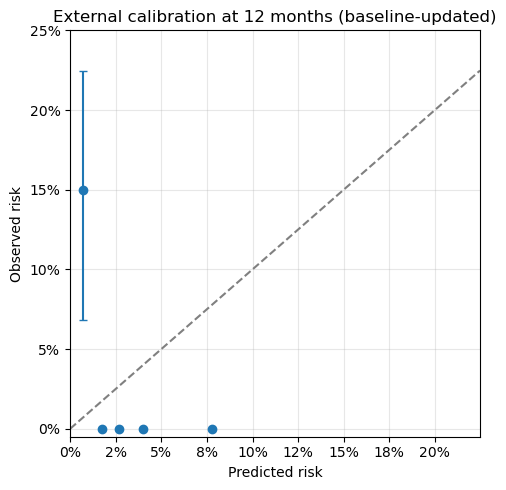

In [25]:

def _first_present(d, keys):
    """Return the first value in d for which d[key] is not None."""
    for k in keys:
        if k in d and d[k] is not None:
            return d[k]
    return None

def plot_calibration_table(
    cal_df,
    title=None,
    percent=True,
    ax=None,
    show_45deg=True,
    clip_zero_ci=True,
):
    if cal_df is None:
        raise ValueError("cal_df is None (no calibration table found in results dict).")

    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))

    req = {"mean_pred", "obs_km", "obs_lo", "obs_hi"}
    missing = req - set(cal_df.columns)
    if missing:
        raise ValueError(f"cal_df missing required columns: {sorted(missing)}")

    x  = cal_df["mean_pred"].to_numpy(dtype=float)
    y  = cal_df["obs_km"].to_numpy(dtype=float)
    lo = cal_df["obs_lo"].to_numpy(dtype=float)
    hi = cal_df["obs_hi"].to_numpy(dtype=float)

    ok = np.isfinite(x) & np.isfinite(y) & np.isfinite(lo) & np.isfinite(hi)
    x, y, lo, hi = x[ok], y[ok], lo[ok], hi[ok]

    yerr_low = y - lo
    yerr_high = hi - y
    if clip_zero_ci:
        yerr_low = np.maximum(yerr_low, 0.0)
        yerr_high = np.maximum(yerr_high, 0.0)

    ax.errorbar(x, y, yerr=np.vstack([yerr_low, yerr_high]), fmt="o", capsize=3)

    maxv = float(np.nanmax(np.r_[x, y, hi])) if len(x) else 1.0
    maxv = max(maxv, 1e-6)

    if show_45deg:
        ax.plot([0, maxv], [0, maxv], "--", color="grey")

    ax.set_xlim(0, maxv)
    ax.set_ylim(0, maxv)
    ax.set_xlabel("Predicted risk")
    ax.set_ylabel("Observed risk")
    if title:
        ax.set_title(title)

    if percent:
        fmt = FuncFormatter(lambda v, p: f"{100*v:.0f}%")
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

    ax.grid(alpha=0.3)
    return ax

# ---- Usage ----
t0 = res_ext["t0_months"]

cal_frozen = _first_present(res_ext, ["calibration_table_frozen", "calibration_table_A"])
cal_updated = _first_present(res_ext, ["calibration_table_updated", "calibration_table_B"])

fig, ax = plt.subplots(figsize=(5, 5))
plot_calibration_table(
    cal_updated,
    title=f"External calibration at {t0} months (baseline-updated)",
    percent=True,
    ax=ax
)
plt.ylim(-0.03, .25)
plt.ylim(-0.005, .25)
plt.tight_layout()
plt.show()


### *Fit a flexible parametric survival model (baseline model) -  The baseline log-cumulative-hazard* 

In [ ]:
with conversion.localconverter(pandas2ri.converter):
    r_miroli0 = pandas2ri.py2rpy(miroli0)

with conversion.localconverter(pandas2ri.converter):
    r_ril_3010 = pandas2ri.py2rpy(ril_3010)

with conversion.localconverter(pandas2ri.converter):
    r_proact0 = pandas2ri.py2rpy(proact0)

In [ ]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age + TRICALS + Diagnostic_Delay + Vital_capacity + Onset_Limb + Sex_Male + Sex_onset')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_miroli0, df=0)
print(ro.r.summary(fp_model))

In [ ]:
def predict_lp_stpm2(model, newdata):
    """
    Compute linear predictor Xβ for stpm2 model
    """
    X = ro.r['predict'](model, newdata=newdata, type="lpmatrix")
    beta = ro.r['coef'](model)
    return ro.r['as.numeric'](X @ beta)


In [ ]:
predictions_full = predict_lp_stpm2(fp_model, r_miroli0)
predictions_full

In [ ]:
# # Define the formula
# formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb + TRICALS + Diagnostic_Delay + Study_Arm_Placebo')

# # Fit the flexible parametric model
# # df = degrees of freedom for spline, adjust as needed
# fp_model = rstpm2.stpm2(formula, data=r_train_df, df=0)
# # print(ro.r.summary(fp_model))

In [ ]:
df_coef = extract_coefficients_from_fp_model_log_haz_scale(fp_model)
df_coef = round(df_coef, 4)
df_coef

In [ ]:
df_coef = extract_coefficients_from_fp_model_haz_scale(fp_model)
df_coef = round(df_coef, 4)
df_coef

In [ ]:
forest_plot_fp_model_haz_scale(extract_coefficients_from_fp_model_haz_scale(fp_model))

In [ ]:
# train_df.columns = train_df.columns.str.replace(' ', '_')
# test_df.columns = test_df.columns.str.replace(' ', '_')
ril_3010.columns

In [ ]:
means = ["Age", "TRICALS", "Diagnostic_Delay"]
modes = ["Sex_Male", "Onset_Limb", "Sex_onset",'Study_Arm_Placebo']

In [ ]:
# Prepare newdata for train and test
times_train = np.linspace(0, train_df["Disease_Duration"].max(), 100)
newdata_train = make_newdata_for_fp_model_prediction(train_df, times_train, means, modes, 'Disease_Duration')

times_test = np.linspace(0, test_df["Disease_Duration"].max(), 100)
newdata_test = make_newdata_for_fp_model_prediction(test_df, times_test, means, modes, 'Disease_Duration')

times_miroli0 = np.linspace(0, miroli0["Disease_Duration"].max(), 100)
newdata_miroli0 = make_newdata_for_fp_model_prediction(miroli0, times_miroli0, means, modes, 'Disease_Duration')

times_ril_3010 = np.linspace(0, ril_3010["Disease_Duration"].max(), 100)
newdata_ril_3010 = make_newdata_for_fp_model_prediction(ril_3010, times_ril_3010, means, modes, 'Disease_Duration')

times_proact0 = np.linspace(0, proact0["Disease_Duration"].max(), 100)
newdata_proact0 = make_newdata_for_fp_model_prediction(proact0, times_proact0, means, modes, 'Disease_Duration')

So while you can generate predictions at 50 months, you cannot validate them.

Prediction may be possible. Validation is not.


If you pretend the second trial has 50 months of follow-up:

You create informative censoring

You inflate uncertainty

You risk misleading conclusions about long-term survival

You can say:

“The model was trained on a 50-month trial and externally validated on an independent 22-month trial. Model performance was assessed at clinically relevant time points up to 22 months.”

In [ ]:
# ril_3010['Disease_Duration'].describe()
# miroli0['Disease_Duration'].describe()
# proact0['Disease_Duration'].describe()

In [ ]:
newdata_miroli0
newdata_ril_3010
# newdata_train

In [ ]:
# import inspect
# inspect.signature(prediction_survival_for_average_patient_fp_model_train_test)

In [ ]:
prediction_survival_for_average_patient_fp_model_train_test(train_df,
                                                            test_df,
                                                            ril_3010,
                                                            fp_model,
                                                            newdata_train=newdata_train,
                                                            newdata_test=newdata_test,
                                                            newdata_valid=newdata_ril_3010,
                                                            time_col='Disease_Duration',
                                                            title_suffix="title_suffix",
                                                            Train_set='Train_set',
                                                            Test_set='Test_set',
                                                            Validation_set='Validation_set')

In [ ]:
newdata_0_train, newdata_1_train = make_newdata_category_for_fp_model_prediction(train_df, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')
newdata_0_test, newdata_1_test = make_newdata_category_for_fp_model_prediction(test_df, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')
newdata_0_valid, newdata_1_valid = make_newdata_category_for_fp_model_prediction(ril_3010, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')

In [ ]:
prediction_survival_for_average_patient_cat_cov_fp_model_train_test(df_train=train_df,
                                                                    df_test=test_df,
                                                                    df_valid=ril_3010,
                                                                    fp_model=fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    newdata_0_valid=newdata_0_valid,
                                                                    newdata_1_valid=newdata_1_valid,
                                                                    time_col="Disease_Duration",
                                                                    title_suffix="",
                                                                    Train_set="",
                                                                    Test_set="",
                                                                    Validation_set=""
                                                                )

In [ ]:
prediction_hazard_for_average_patient_fp_model_train_test(
    train_df,
    test_df,
    ril_3010,
    fp_model,
    newdata_train=newdata_train,
    newdata_test=newdata_test,
    newdata_valid=newdata_ril_3010,
    time_col='Disease_Duration',
    title_suffix="title_suffix",
    Train_set='Train_set',
    Test_set='Test_set',
    Validation_set='Validation_set')

In [ ]:
prediction_hazard_for_average_patient_cat_cov_fp_model_train_test(df_train=train_df,
                                                                    df_test=test_df,
                                                                    df_valid=ril_3010,
                                                                    fp_model=fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    newdata_0_valid=newdata_0_valid,
                                                                    newdata_1_valid=newdata_1_valid,
                                                                    time_col="Disease_Duration",
                                                                    title_suffix="",
                                                                    Train_set="",
                                                                    Test_set="",
                                                                    Validation_set=""
                                                                )

## Prognostic Scores for Baseline Model (fit)

In [ ]:
train_df = prognostic_score(train_df, fp_model, groups=3)
train_df.head(3)

In [ ]:
train_df['risk_group'] = pd.qcut(train_df['prognostic_score'], 3, labels=['Low','Medium','High'])

train_df.head(6)
train_df.risk_group.value_counts().to_dict()

In [ ]:
for group in ['Low','Medium','High']:
    subset = train_df[train_df['risk_group']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

## ***Simulate Virtual Placebo***

In [ ]:
train_df.info()

In [ ]:
cols = ['subject_id']

for col in (train_df.select_dtypes(include=['object', 'category', 'int']).columns):
    if col not in cols:
        print(f"{train_df[col].value_counts() / train_df[col].value_counts().sum()}\n")

In [ ]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
pla = train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()
# exp = train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()
# eur = train_df['European_Yes'].value_counts() / train_df['European_Yes'].value_counts().sum()


In [ ]:
ons, sex

In [ ]:
train_df.head(3)

In [ ]:
train_df.columns

In [ ]:
train_df.head(3)

In [ ]:
corr = train_df[['Age','Study_Arm_Placebo','Diagnostic_Delay','Vital_capacity','Sex_Male', 
            	 'Onset_Limb','TRICALS']].corr()
corr

In [ ]:
df = df_coef.copy()
df

In [ ]:
# df.loc[df["Variable"] == "Age", "Estimate"].values[0]
# ons
# sex[1]
# pla[1]

In [ ]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "Age", "Estimate"].values[0]},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "TRICALS", "Estimate"].values[0]},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Diagnostic_Delay", "Estimate"].values[0]},
    # {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
    #                                                        'coef':df.loc[df["Variable"] == "Vital capacity", "Estimate"].values[0]},

    # binary
    {'name':'Sex_Male','type':'binary','prob':sex[1],'coef':df.loc[df["Variable"] == "Sex_Male", "Estimate"].values[0]},
    {'name':'Onset_Limb','type':'binary','prob':ons[1],'coef':df.loc[df["Variable"] == "Onset_Limb", "Estimate"].values[0]},
    # {'name':'Expt_mirocals','type':'binary','prob':exp[1],'coef':df.loc[df["Variable"] == "Expt_mirocals", "Estimate"].values[0]},
    {'name':'Study_Arm_Placebo','type':'binary','prob':pla[1],'coef':df.loc[df["Variable"] == "Study_Arm_Placebo", "Estimate"].values[0]},

    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
]

corr = train_df[['Age', 'TRICALS', 'Diagnostic_Delay','Sex_Male', 'Onset_Limb', 'Study_Arm_Placebo']].corr()

# df_sim = simulate_cox_dataset(n=df1.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
#                               censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


# df_sim.head(3)

In [ ]:
train_df.Event.value_counts() / train_df.Event.value_counts().sum()

In [ ]:
H0_df = estimate_baseline_cumhaz(train_df, time_col='Disease_Duration', event_col='Event')
# H0_df

In [ ]:
# Real dataset
# H0_df = estimate_baseline_cumhaz(real_df)

# Simulated dataset
sim_df = simulate_cox_dataset_with_correlation(
    # n=500,
    n=train_df.shape[0],
    var_specs=var_specs_real,
    corr=corr,
    baseline="empirical",
    H0_df=H0_df,
    censor_rate=0.4,
    seed=42
)


In [ ]:
sim_df.head(3)

In [ ]:
# Create interactions
sim_df['Sex_onset'] = sim_df['Sex_Male']*sim_df['Onset_Limb']
sim_df.head(3)

In [ ]:
sim_df.event.value_counts() #/ sim_df.event.value_counts().sum()

In [ ]:
train_df.head(3)

In [ ]:
train_df.Event.value_counts() #/ train_df.event.value_counts().sum()

In [ ]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
sex_ons = train_df['Sex_onset'].value_counts() / train_df['Sex_onset'].value_counts().sum()
print(ons, sex, sex_ons)

print("\n---- Simulated data ----")
ons1 = sim_df['Onset_Limb'].value_counts() / sim_df['Onset_Limb'].value_counts().sum()
sex1 = sim_df['Sex_Male'].value_counts() / sim_df['Sex_Male'].value_counts().sum()
sex_ons1 = sim_df['Sex_onset'].value_counts() / sim_df['Sex_onset'].value_counts().sum()

print(ons1, sex1, sex_ons1)

In [ ]:
with conversion.localconverter(pandas2ri.converter):
    r_df_sim = pandas2ri.py2rpy(sim_df)

In [ ]:
# # Define the formula
formula1 = Formula('Surv(true_survival_time, event==1) ~ Age + Study_Arm_Placebo + Onset_Limb + TRICALS + Sex_Male + Diagnostic_Delay')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model1 = rstpm2.stpm2(formula1, data=r_df_sim, df=0)
# print(ro.r.summary(fp_model1))

In [ ]:
df_coef1 = extract_coefficients_from_fp_model_haz_scale(fp_model1)
df_coef1

In [ ]:
df_coef

In [ ]:
coefs = pd.merge(df_coef, df_coef1, on="Variable", suffixes=('_real', '_simulated'))
coefs = round(coefs, 4)
coefs

In [ ]:
coefs1 = coefs[['Variable', 'Estimate_real', 'Estimate_simulated']]
coefs1

In [ ]:
x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["Estimate_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["Estimate_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
coefs1 = coefs[['Variable', 'HR_real', 'HR_simulated']]
coefs1

x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["HR_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["HR_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(train_df[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_df[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

In [ ]:
cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(train_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_ind

cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

results = []

for col in cols:
    original = train_df[col].dropna()
    simulated = sim_df[col].dropna()

    # Welch t-test
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)

    # Mean difference
    mean_diff = simulated.mean() - original.mean()

    # Standard errors for CI (Welch)
    se = np.sqrt(original.var()/len(original) + simulated.var()/len(simulated))

    # 95% CI
    ci_low = mean_diff - 1.96 * se
    ci_high = mean_diff + 1.96 * se

    results.append([col, mean_diff, ci_low, ci_high, p_val])

df_plot = pd.DataFrame(results, columns=["Variable", "MeanDiff", "CI_low", "CI_high", "p_value"])


# --------- Forest Plot ---------
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    df_plot["MeanDiff"], 
    y_pos, 
    xerr=[df_plot["MeanDiff"] - df_plot["CI_low"], df_plot["CI_high"] - df_plot["MeanDiff"]],
    fmt='o', 
    capsize=5
)

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Mean Difference (Simulated − Original)")
plt.title("Forest Plot of T-Test Mean Differences")

plt.tight_layout()
plt.show()

In [ ]:
# remove the interaction term from the model